In [1]:
import os
import copy
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
from collections import Counter
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda:0


## Priprema Skupa Podataka i Transformacije

U ovoj ćeliji postavljamo skup podataka i transformacije za treniranje naših modela.

- **Putanje**: Definišemo glavnu putanju gde se nalaze slike skupa podataka.
- **Transformacije**: Primenjujemo seriju transformacija na slike:
  - **Treniranje**: Uključujemo promenu veličine, nasumičnu rotaciju, konverziju u tensor, afine transformacije (blaga rotacija, translacija, skaliranje), nasumično brisanje i normalizaciju.
  - **Validacija/Test**: Uključujemo promenu veličine, konverziju u tensor i normalizaciju.
- **Skup Podataka**: Koristimo `ImageFolder` za učitavanje slika iz navedenog direktorijuma.
- **Deljenje**: Delimo skup podataka na trening, validacione i testne podskupove uz obezbeđivanje stratifikacije za očuvanje raspodele klasa.
- **DataLoaders**: Kreiramo DataLoader-e za svaki podskup sa odgovarajućim veličinama serija.


In [3]:
# Paths
root_path = '/content/drive/MyDrive/Colab Notebooks/sketches_png/png'

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # slight rotation, translation, scaling
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.06)),  # randomly erases part of the image
    transforms.Normalize([0.5], [0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(root=root_path)

labels = [dataset.imgs[i][1] for i in range(len(dataset))]

train_val_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.1,
    stratify=[labels[i] for i in train_val_indices],
    random_state=42
)

train_dataset = Subset(datasets.ImageFolder(root=root_path, transform=train_transform), train_indices)
val_dataset = Subset(datasets.ImageFolder(root=root_path, transform=val_test_transform), val_indices)
test_dataset = Subset(datasets.ImageFolder(root=root_path, transform=val_test_transform), test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'validation': val_loader, 'test': test_loader}


## Prikaz Raspodele Klasa

U ovoj ćeliji koristimo funkciju za prikaz raspodele klasa u trening, validacionom i testnom skupu podataka.

- **Funkcija `plot_class_distribution`**:
  - Izvlači labele iz datog skupa podataka.
  - Računa broj instanci po klasi koristeći `Counter`.
  - Prikazuje raspodelu klasa kao bar graf, gde su klase prikazane na X-osi, a broj slika na Y-osi.
  
- Prikazujemo grafike za trening, validacioni i testni skup podataka.



In [4]:
def plot_class_distribution(subset, title):
    labels = [subset.dataset.imgs[i][1] for i in subset.indices]

    class_counts = Counter(labels)

    all_class_counts = [class_counts[i] if i in class_counts else 0 for i in range(len(subset.dataset.classes))]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(range(len(subset.dataset.classes))), y=all_class_counts, hue=list(range(len(subset.dataset.classes))), palette="viridis", legend=False)
    plt.xticks(ticks=list(range(len(subset.dataset.classes))), labels=subset.dataset.classes, rotation=90)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.tight_layout()
    plt.show()


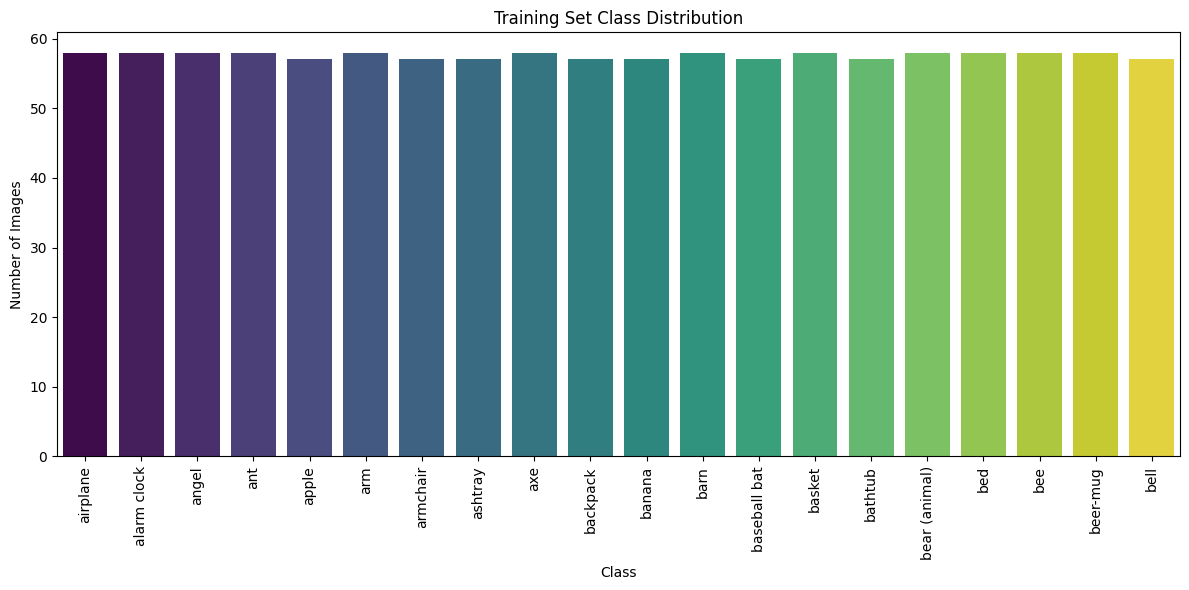

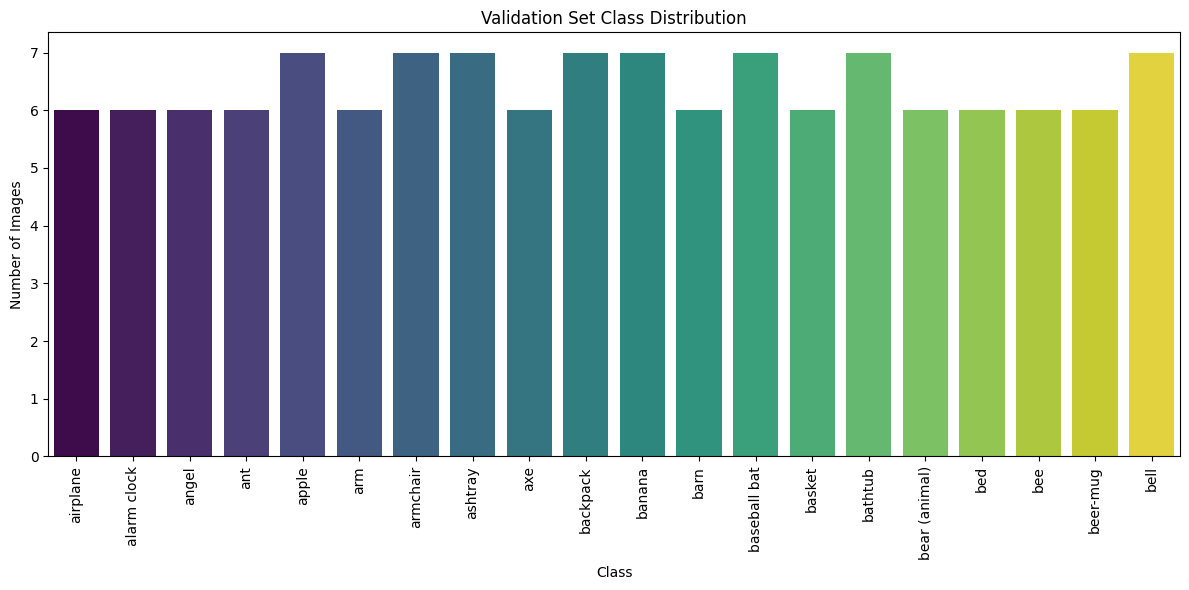

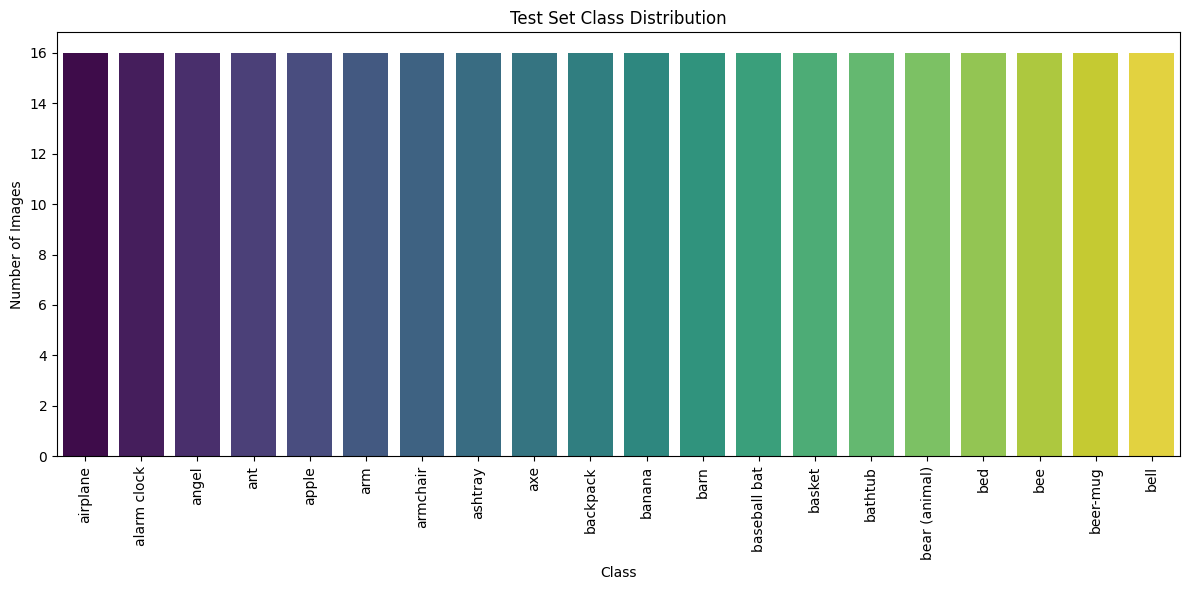

In [5]:
# Plot class distributions for train, validation, and test sets
plot_class_distribution(train_dataset, "Training Set Class Distribution")
plot_class_distribution(val_dataset, "Validation Set Class Distribution")
plot_class_distribution(test_dataset, "Test Set Class Distribution")

In [5]:
len(train_loader.dataset), len(test_loader.dataset), len(val_loader.dataset), len(dataset)

(1152, 320, 128, 1600)

## Vizualizacija Slika iz Skupa Podataka

U ovoj ćeliji kreiramo funkciju za vizualizaciju uzoraka slika iz bilo kog DataLoader-a.

- **Funkcija `tensor_to_pil`**: Konvertuje tenzore slika u PIL slike za lakšu vizualizaciju.
- **Funkcija `draw_images`**:
  - Učitava jednu seriju slika iz prosledjenog `loader`-a.
  - Nasumično bira 9 slika iz serije za prikaz.
  - Prikazuje nasumične slike u mreži 3x3 sa njihovim oznakama koristeći `matplotlib`.



In [6]:
def tensor_to_pil(tensor):
    transform = transforms.ToPILImage()
    return transform(tensor)

def draw_images(loader, title):
  # Get a batch of images from the train loader
  images, labels = next(iter(loader))

  sample_indices = random.sample(range(len(images)), 9)
  class_names = loader.dataset.dataset.classes
  plt.figure(figsize=(10, 10))
  for i, idx in enumerate(sample_indices):
      img_tensor = images[idx]
      img_pil = tensor_to_pil(img_tensor)

      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(img_pil)
      plt.title(f"Label: {loader.dataset.dataset.classes[labels[idx]]}")
      plt.axis("off")

  plt.suptitle(title, fontsize=14)
  plt.show()


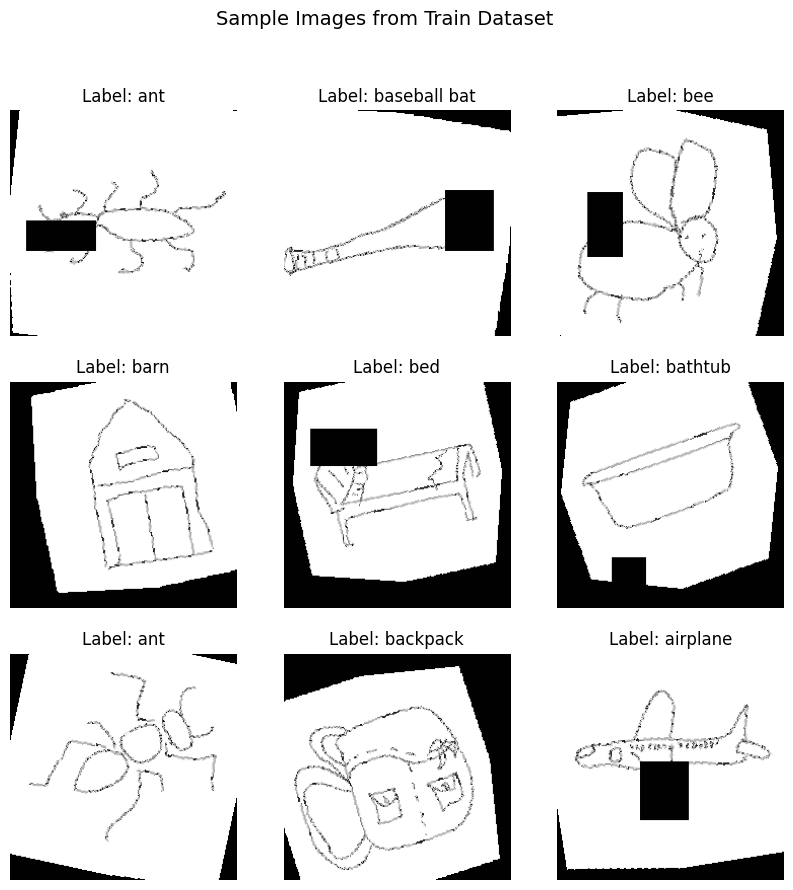

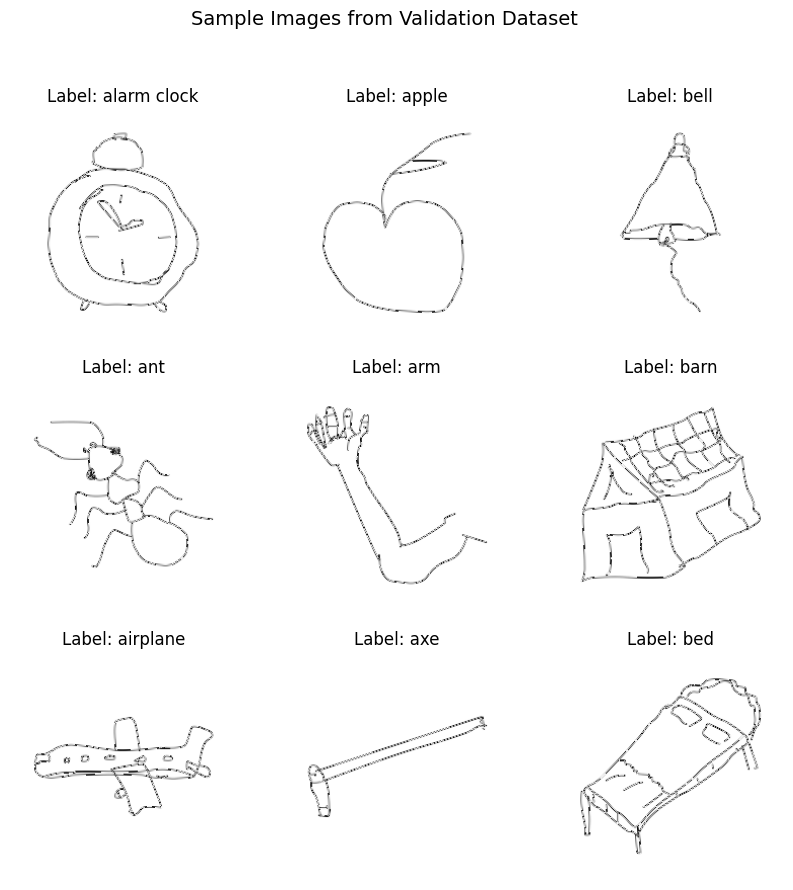

In [7]:
draw_images(train_loader, "Sample Images from Train Dataset")
draw_images(val_loader, "Sample Images from Validation Dataset")

## Učitavanje i Prilagođavanje Pre-Treniranog VGG16 Modela

U ovoj ćeliji učitavamo pre-treniran VGG16 model i prilagođavamo ga za naš skup podataka.

- **Učitavanje Modela**: Učitavamo pre-treniran VGG16 model sa težinama obučavanim na ImageNet-u.
- **Zamrzavanje Slojeva**: Postavljamo `requires_grad` za sve parametre modela na `False`, kako bismo zamrzli sve slojeve.
- **Modifikacija Klasiifikatora**: Menjamo poslednji sloj klasiifikatora modela kako bi odgovarao broju klasa u našem skupu podataka (20 klasa).
- **Kriterijum i Optimizator**: Definišemo kriterijum (CrossEntropyLoss) i postavljamo osnovne hiperparametre za trening (brzina učenja i broj epoha).
- **Putanje za Čuvanje Modela i Plotova**: Postavljamo putanje za čuvanje modela i plotova, i kreiramo odgovarajuće direktorijume ako ne postoje.



In [8]:
# Load pre-trained VGG16 model
baseline_model = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
print(baseline_model.classifier)

# Freeze all layers
for param in baseline_model.parameters():
    param.requires_grad = False

# Modify the classifier
num_ftrs = baseline_model.classifier[6].in_features
baseline_model.classifier[6] = nn.Linear(num_ftrs, 20)  # 20 classes

baseline_model = baseline_model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate_baseline = 0.001
num_epochs_baseline = 50

# Path for saving models and plots
model_save_path = './models'
os.makedirs(model_save_path, exist_ok=True)

plots_save_path = './plots'
os.makedirs(plots_save_path, exist_ok=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.8MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


## Treniranje Modela

U ovoj ćeliji treniramo model koristeći zadate hiperparametre i funkcije za optimizaciju.

- **Funkcija `train_model`**:
  - **Argumenti**:
    - `model`: Model koji se obučava.
    - `dataloaders`: DataLoader-i za obučavanje i validaciju.
    - `criterion`: Funkcija gubitka.
    - `optimizer`: Optimizator.
    - `num_epochs`: Broj epoha za obuku.
    - `is_finetune`: Da li je u pitanju fine-tuning modela.
    - `patience`: Broj epoha bez poboljšanja pre nego što se zaustavi obuka (early stopping).
    - `scheduler`: Opcioni raspoređivač učenja.
    - `weight_init`: Opcioni inicijalizator težina.
  - **Proces**:
    - Ako je dat `weight_init`, primenjujemo ga na model.
    - U svakoj epohi, obučavamo model i pratimo gubitak i tačnost na obučavajućem skupu.
    - Validiramo model i pratimo gubitak i tačnost na validacionom skupu.
    - Koristimo early stopping ako se gubitak na validacionom skupu ne poboljšava.
    - Čuvamo najbolji model prema gubitku i tačnosti.
  - **Rezultati**:
    - Vraća obučeni model, najbolju tačnost na validacionom skupu, gubitke i tačnosti tokom obuke i validacije.

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_finetune=False, patience=5, scheduler = None, weight_init = None):
    since = time.time()

    if weight_init is not None:
      model.apply(weight_init)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    train_loader, validation_loader = dataloaders['train'], dataloaders['validation']

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(validation_loader.dataset)
        val_acc = val_running_corrects.double() / len(validation_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if scheduler is not None:
            scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            model_path = 'vgg16_finetuned.pth' if is_finetune else 'vgg16_baseline.pth'
            torch.save(model.state_dict(), os.path.join(model_save_path, model_path))
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}")
            early_stop = True
            break

        print()

    if not early_stop:
        best_acc = val_acc

    time_elapsed = time.time() - since
    print(f"Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, best_acc.item(), train_losses, val_losses, train_accuracies, val_accuracies


## Prikaz Metrika

U ovoj ćeliji vizualizujemo metrike obuke i validacije kako bismo pratili performanse modela tokom obuke.

- **Funkcija `plot_metrics`**:
  - **Argumenti**:
    - `train_losses`: Lista gubitaka na trening skupu tokom epoha.
    - `val_losses`: Lista gubitaka na validacionom skupu tokom epoha.
    - `train_accuracies`: Lista tačnosti na trening skupu tokom epoha.
    - `val_accuracies`: Lista tačnosti na validacionom skupu tokom epoha.
    - `is_finetune`: Da li je u pitanju fine-tuning modela.
  - **Proces**:
    - Kreiramo dva subplot-a:
      - Prvi prikazuje gubitak tokom epoha za trening i validacioni skup.
      - Drugi prikazuje tačnost tokom epoha za trening i validacioni skup.



In [9]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, is_finetune=False):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plotting losses (Train and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting accuracies (Train and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plot_type = 'Fine-Tuned' if is_finetune else 'Baseline'
    plt.savefig(f"./plots/metrics_plot_{plot_type}_{val_accuracies[-1]:.4f}.png")

## Fine-tuning Modela

U ovoj ćeliji fine tune-ujemo model koristeći funkciju za obuku sa dodatnim podešavanjima.

- **Funkcija `fine_tune_model`**:
  - **Argumenti**:
    - `model`: Model koji treba fine tune-ovati.
    - `dataloaders`: DataLoader-i za trening i validaciju.
    - `criterion`: Funkcija gubitka.
    - `optimizer`: Opcioni optimizator, kreiramo Adam ako nije dat.
    - `num_epochs`: Broj epoha.
    - `patience`: Broj epoha bez poboljšanja pre nego što se zaustavi obuka (early stopping).
  - **Proces**:
    - Ako optimizator nije dat, kreiramo Adam optimizator sa malom brzinom učenja i weight decay.
    - Koristimo `ReduceLROnPlateau` scheduler za prilagođavanje brzine učenja tokom epoha.
    - Postavljamo sve slojeve modela da budu obučivi(unfreeze-ujemo ih).
    - Pozivamo funkciju `train_model` za obuku modela.
  - **Rezultati**:
    - Vraća fine-tunned model, najbolju tačnost, gubitke i tačnosti tokom obuke i validacije.



In [11]:
def fine_tune_model(model, dataloaders, criterion, optimizer=None, num_epochs=10, patience=5):
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)
    for param in model.parameters():
        param.requires_grad = True

    model, best_acc, train_losses, val_losses, train_acuracies, val_accuracies = train_model(
        model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_finetune=True, patience=patience, scheduler = scheduler
    )

    return model, best_acc, train_losses, val_losses, train_acuracies, val_accuracies


## Treniranje Baseline Modela

U ovoj ćeliji treniramo baseline model koristeći prethodno definisane hiperparametre i funkcije.

- **Obuka Baseline Modela**:
  - Definišemo optimizator za baseline model koristeći Adam sa zadatom brzinom učenja.
  - Postavljamo `patience` na 5 za rano zaustavljanje.
  - Pozivamo funkciju `train_model` da treniramo baseline model.
  - Ispisujemo tačnost modela na trening skupu.

- **Vizualizacija Metrika**:
  - Koristimo funkciju `plot_metrics` za prikaz gubitaka i tačnosti tokom epoha za baseline model.



=== Training Baseline Model ===
Epoch 1/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.31it/s]


Train Loss: 2.8831 Acc: 0.1337
Val Loss: 2.7808 Acc: 0.1328

Epoch 2/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.33it/s]


Train Loss: 2.4081 Acc: 0.2292
Val Loss: 2.5991 Acc: 0.2422

Epoch 3/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.30it/s]


Train Loss: 2.3049 Acc: 0.2882
Val Loss: 2.4835 Acc: 0.2344

Epoch 4/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.33it/s]


Train Loss: 2.1538 Acc: 0.3186
Val Loss: 2.4394 Acc: 0.2344

Epoch 5/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.29it/s]


Train Loss: 2.1557 Acc: 0.3411
Val Loss: 2.3177 Acc: 0.2578

Epoch 6/50
----------


100%|██████████| 36/36 [00:28<00:00,  1.28it/s]


Train Loss: 2.0985 Acc: 0.3377
Val Loss: 2.2902 Acc: 0.3359

Epoch 7/50
----------


100%|██████████| 36/36 [00:28<00:00,  1.28it/s]


Train Loss: 2.0327 Acc: 0.3455
Val Loss: 2.2104 Acc: 0.3359

Epoch 8/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.31it/s]


Train Loss: 2.0662 Acc: 0.3490
Val Loss: 2.1955 Acc: 0.3359

Epoch 9/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.29it/s]


Train Loss: 2.0219 Acc: 0.3620
Val Loss: 2.0462 Acc: 0.3828

Epoch 10/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.32it/s]


Train Loss: 1.9809 Acc: 0.3759
Val Loss: 2.0130 Acc: 0.3906

Epoch 11/50
----------


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


Train Loss: 2.0104 Acc: 0.3524
Val Loss: 1.9238 Acc: 0.4609

Epoch 12/50
----------


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


Train Loss: 1.9485 Acc: 0.3681
Val Loss: 2.0057 Acc: 0.4062

Epoch 13/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.30it/s]


Train Loss: 1.9741 Acc: 0.3811
Val Loss: 1.9167 Acc: 0.4609

Epoch 14/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.33it/s]


Train Loss: 2.0092 Acc: 0.3594
Val Loss: 1.7862 Acc: 0.5000

Epoch 15/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.30it/s]


Train Loss: 1.8971 Acc: 0.4115
Val Loss: 1.9275 Acc: 0.4375

Epoch 16/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.33it/s]


Train Loss: 1.9568 Acc: 0.3733
Val Loss: 1.9066 Acc: 0.4844

Epoch 17/50
----------


100%|██████████| 36/36 [00:28<00:00,  1.27it/s]


Train Loss: 1.9205 Acc: 0.3854
Val Loss: 1.9635 Acc: 0.4062

Epoch 18/50
----------


100%|██████████| 36/36 [00:26<00:00,  1.34it/s]


Train Loss: 1.8672 Acc: 0.3993
Val Loss: 1.7364 Acc: 0.4922

Epoch 19/50
----------


100%|██████████| 36/36 [00:26<00:00,  1.35it/s]


Train Loss: 1.9302 Acc: 0.3889
Val Loss: 1.8024 Acc: 0.4844

Epoch 20/50
----------


100%|██████████| 36/36 [00:26<00:00,  1.35it/s]


Train Loss: 1.8931 Acc: 0.4132
Val Loss: 1.8517 Acc: 0.4609

Epoch 21/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.33it/s]


Train Loss: 1.9351 Acc: 0.3819
Val Loss: 1.8314 Acc: 0.4844

Epoch 22/50
----------


100%|██████████| 36/36 [00:27<00:00,  1.33it/s]


Train Loss: 1.8808 Acc: 0.4010
Val Loss: 1.8970 Acc: 0.4219

Epoch 23/50
----------


100%|██████████| 36/36 [00:28<00:00,  1.27it/s]


Train Loss: 1.8713 Acc: 0.4028
Val Loss: 1.8819 Acc: 0.3984
Early stopping at epoch 23
Training complete in 12m 4s
Best Val Acc: 0.4922
Baseline Train Accuracy: 49.22%



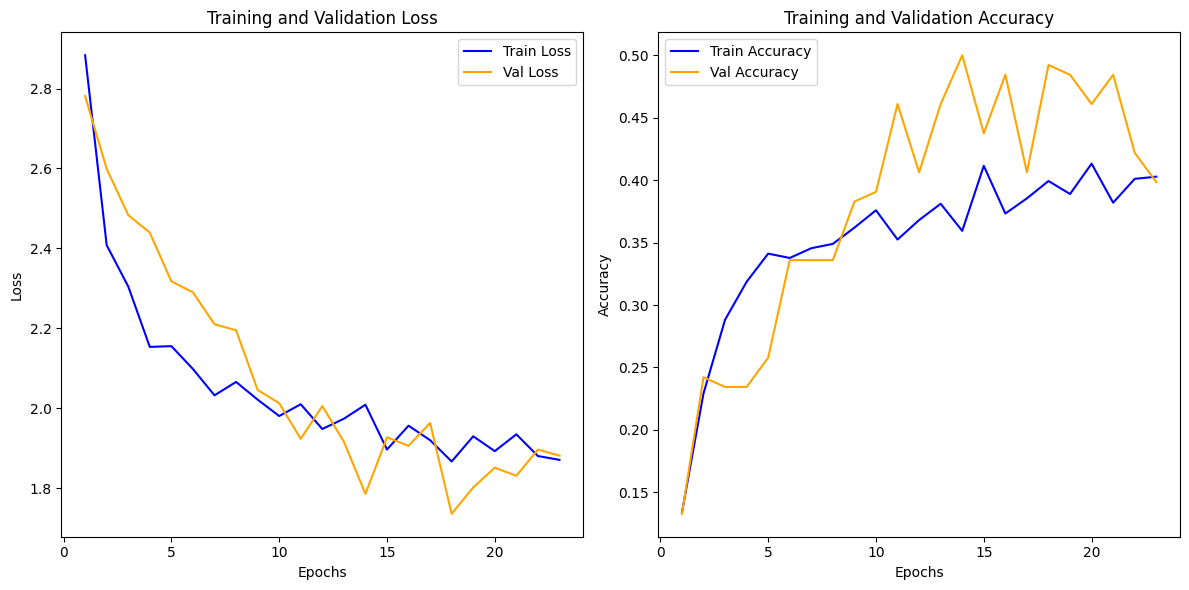

<Figure size 640x480 with 0 Axes>

In [21]:
# Baseline Training
print("=== Training Baseline Model ===")
optimizer_baseline = optim.Adam(filter(lambda p: p.requires_grad, baseline_model.parameters()), lr=learning_rate_baseline)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_baseline, mode='min', patience=2, verbose=True)
patience = 5

best_baseline_model, baseline_acc, baseline_train_losses, baseline_val_losses, baseline_train_accuracies, baseline_val_accuracies = train_model(
    baseline_model,
    dataloaders,
    criterion,
    optimizer_baseline,
    num_epochs=num_epochs_baseline,
    is_finetune=False,
    patience=patience,
    scheduler = None
)

print(f"Baseline Train Accuracy: {baseline_acc * 100:.2f}%\n")

plot_metrics(baseline_train_losses, baseline_val_losses, baseline_train_accuracies, baseline_val_accuracies, is_finetune=False)




Kao što se može primetiti, rezultati su bili znatno bolji na validacionom skupu nego na trening skupu. Ova razlika može se pripisati tehnikama regularizacije, kao i činjenici da je skup za treniranje bio znatno teži u poređenju sa validacionim skupom (slike za treniranje su bile rotirane i delimično izbrisane).

## Trening Fine-tuning Modela

U ovoj ćeliji podešavamo model koristeći prethodno definisane metode i hiperparametre.

- **Priprema Modela za Fine-tunning**:
  - Kreiramo novi VGG16 model sa pretreniranom težinom.
  - Modifikujemo poslednji sloj modela dodajući dva `Linear` sloja, `BatchNorm1d`, `ReLU`, i `Dropout`.
  - Zamrzavamo poslednjih 10 slojeva karakteristika modela da bi se samo preostali slojevi obučavali.

- **Treniranje Modela**:
  - Koristimo funkciju `fine_tune_model` za podešavanje modela.
  - Ispisujemo tačnost modela na trening skupu nakon fine-tuninga.

- **Vizualizacija Metrika**:
  - Koristimo funkciju `plot_metrics` za prikaz gubitaka i tačnosti tokom epoha za  podešeni model.



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=20, bias=True)
  )
)
=== Fine-Tuning the Model ===
Epoch 1/50
----------


100%|██████████| 36/36 [06:48<00:00, 11.35s/it]


Train Loss: 3.0946 Acc: 0.0573
Val Loss: 2.8052 Acc: 0.1328

Epoch 2/50
----------


100%|██████████| 36/36 [00:38<00:00,  1.08s/it]


Train Loss: 2.8164 Acc: 0.1380
Val Loss: 2.6803 Acc: 0.2109

Epoch 3/50
----------


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


Train Loss: 2.3683 Acc: 0.3290
Val Loss: 1.9838 Acc: 0.5547

Epoch 4/50
----------


100%|██████████| 36/36 [00:40<00:00,  1.11s/it]


Train Loss: 2.0123 Acc: 0.4800
Val Loss: 1.8366 Acc: 0.5547

Epoch 5/50
----------


100%|██████████| 36/36 [00:40<00:00,  1.12s/it]


Train Loss: 1.6934 Acc: 0.6389
Val Loss: 1.6246 Acc: 0.6641

Epoch 6/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.10s/it]


Train Loss: 1.4658 Acc: 0.7344
Val Loss: 1.2815 Acc: 0.7109

Epoch 7/50
----------


100%|██████████| 36/36 [00:40<00:00,  1.14s/it]


Train Loss: 1.2449 Acc: 0.7995
Val Loss: 1.1553 Acc: 0.7500

Epoch 8/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.10s/it]


Train Loss: 1.0919 Acc: 0.8550
Val Loss: 1.1925 Acc: 0.7969

Epoch 9/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.10s/it]


Train Loss: 0.9574 Acc: 0.8828
Val Loss: 1.1345 Acc: 0.7969

Epoch 10/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.11s/it]


Train Loss: 0.8689 Acc: 0.9019
Val Loss: 0.9691 Acc: 0.8438

Epoch 11/50
----------


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


Train Loss: 0.7581 Acc: 0.9245
Val Loss: 0.9299 Acc: 0.8047

Epoch 12/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


Train Loss: 0.7004 Acc: 0.9358
Val Loss: 0.9495 Acc: 0.8125

Epoch 13/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


Train Loss: 0.6296 Acc: 0.9523
Val Loss: 0.9185 Acc: 0.8359

Epoch 14/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.10s/it]


Train Loss: 0.5603 Acc: 0.9679
Val Loss: 0.8316 Acc: 0.7891

Epoch 15/50
----------


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


Train Loss: 0.5140 Acc: 0.9783
Val Loss: 0.8001 Acc: 0.8281

Epoch 16/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


Train Loss: 0.4645 Acc: 0.9792
Val Loss: 0.8345 Acc: 0.8047

Epoch 17/50
----------


100%|██████████| 36/36 [00:38<00:00,  1.08s/it]


Train Loss: 0.4260 Acc: 0.9783
Val Loss: 0.8047 Acc: 0.8047

Epoch 18/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.10s/it]


Train Loss: 0.3843 Acc: 0.9870
Val Loss: 0.7794 Acc: 0.8047

Epoch 19/50
----------


100%|██████████| 36/36 [00:40<00:00,  1.13s/it]


Train Loss: 0.3821 Acc: 0.9818
Val Loss: 0.7734 Acc: 0.8359

Epoch 20/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.10s/it]


Train Loss: 0.3643 Acc: 0.9826
Val Loss: 0.7174 Acc: 0.8203

Epoch 21/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


Train Loss: 0.3480 Acc: 0.9774
Val Loss: 0.7234 Acc: 0.8281

Epoch 22/50
----------


100%|██████████| 36/36 [00:38<00:00,  1.08s/it]


Train Loss: 0.3017 Acc: 0.9896
Val Loss: 0.7274 Acc: 0.8359

Epoch 23/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


Train Loss: 0.2675 Acc: 0.9939
Val Loss: 0.6639 Acc: 0.8516

Epoch 24/50
----------


100%|██████████| 36/36 [00:40<00:00,  1.12s/it]


Train Loss: 0.2542 Acc: 0.9965
Val Loss: 0.6389 Acc: 0.8281

Epoch 25/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.11s/it]


Train Loss: 0.2577 Acc: 0.9870
Val Loss: 0.7214 Acc: 0.8281

Epoch 26/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


Train Loss: 0.2623 Acc: 0.9870
Val Loss: 0.7064 Acc: 0.8125

Epoch 27/50
----------


100%|██████████| 36/36 [00:39<00:00,  1.09s/it]


Train Loss: 0.2477 Acc: 0.9878
Val Loss: 0.7441 Acc: 0.8047
Early stopping at epoch 27
Training complete in 26m 37s
Best Val Acc: 0.8281
Fine-Tuned Train Accuracy: 82.81%



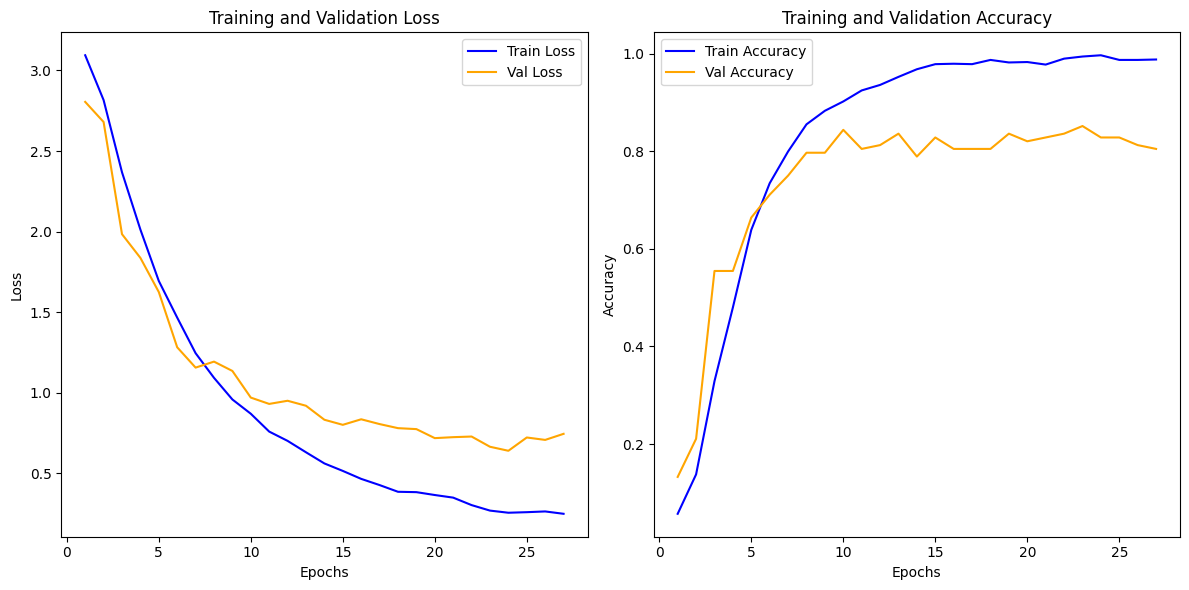

<Figure size 640x480 with 0 Axes>

In [16]:
# Fine-Tuning

baseline_model_1 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
print(baseline_model_1.classifier)
num_epochs_finetune = 50

num_ftrs = baseline_model_1.classifier[6].in_features
baseline_model_1.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 20)
)

for param in baseline_model_1.features[:-10].parameters():
    param.requires_grad = False

baseline_model_1 = baseline_model_1.to(device)

print(baseline_model_1.classifier)

print("=== Fine-Tuning the Model ===")
fine_tuned_model, finetuned_acc, finetune_train_losses, finetune_val_losses, finetune_train_accuracies, finetune_val_accuracies = fine_tune_model(
    baseline_model_1,
    dataloaders,
    criterion,
    optimizer=None,
    num_epochs=num_epochs_finetune,
    patience=3
)

print(f"Fine-Tuned Train Accuracy: {finetuned_acc * 100:.2f}%\n")

plot_metrics(finetune_train_losses, finetune_val_losses, finetune_train_accuracies, finetune_val_accuracies, is_finetune=True)


Kao što se može videti iz rezultata, model je pokazao određeni stepen preprilagođavanja. Ovaj problem smo pokušali da rešimo na različite načine, ali bez uspeha. Smatramo da je uzrok to što je skup podataka koji se koristi za treniranje prilično mali (za svaku klasu imamo samo 80 slika, od kojih se 56 koristi za treniranje; uz to, slike su ručno crtane, pa su i same po sebi prilično različite). Prvo smo pretpostavili da je problem u tome što je mreža previše složena za naš skup podataka, pa smo iz tog razloga zamrzli prvih 10 slojeva, ali ni to nije eliminisalo preprilagođavanje. Zatim smo dodali L2 regularizaciju i dropout, ali ni to nije pomoglo. Takođe smo odlučili da dodatno otežamo slike na kojima se model trenira, rotiranjem i brisanjem delova slika. Iako ovde izgleda kao da se model znatno preprilagodio, rezultati su dosta bolji na test podacima.

## Evaluacija Modela

U ovoj ćeliji evaluiramo performanse modela na test skupu koristeći metrike kao što su gubitak, tačnost, matrica konfuzije i izveštaj o klasifikaciji.

- **Funkcija `evaluate_model`**:
  - **Argumenti**:
    - `model`: Model koji se evaluira.
    - `dataloaders`: DataLoader za test skup.
    - `criterion`: Funkcija gubitka.
  - **Proces**:
    - Postavljamo model u režim evaluacije.
    - Iteriramo kroz test skup i računamo gubitak i tačnost modela.
    - Čuvamo predikcije, stvarne labele, ulaze i predikcije za dalje analize.
    - Prikazujemo matricu konfuzije koristeći `seaborn`.
    - Prikazujemo izveštaj o klasifikaciji.
  - **Rezultati**:
    - Vraća testni gubitak, testnu tačnost, tensor ulaza, tensor labela i tensor predikcija.



In [17]:
def evaluate_model(model, dataloaders, criterion):
    model.eval()
    test_loader = dataloaders['test']
    all_preds = []
    all_labels = []
    inputs_list = []
    labels_list = []
    preds_list = []
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            inputs_list.extend(inputs.cpu())
            labels_list.extend(labels.cpu())
            preds_list.extend(preds.cpu())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=dataloaders['test'].dataset.dataset.classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataloaders['test'].dataset.dataset.classes,
                yticklabels=dataloaders['test'].dataset.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:")
    print(class_report)

    return test_loss, test_acc.item(), torch.stack(inputs_list), torch.tensor(labels_list), torch.tensor(preds_list)


## Prikaz Pogrešno Klasifikovanih Slika

U ovoj ćeliji prikazujemo slike koje je model pogrešno klasifikovao.

- **Funkcija `plot_misclassified_images`**:
  - **Argumenti**:
    - `inputs`: Tenzori slika iz skupa podataka.
    - `labels`: Stvarne labele slika.
    - `preds`: Predikcije modela za slike.
    - `num_images`: Broj slika koje želimo da prikažemo (podrazumevano 5).
  - **Proces**:
    - Identifikujemo slike koje su pogrešno klasifikovane i čuvamo ih zajedno sa stvarnim labelama i predikcijama.
    - Prikazujemo prvih nekoliko pogrešno klasifikovanih slika u mreži sa naslovima koji prikazuju stvarne labele i predikcije.
  - **Rezultati**:
    - Prikazujemo slike i njihove labele sa stvarnim i predviđenim klasama.



In [18]:
def plot_misclassified_images(inputs, labels, preds, num_images=5):
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    for i in range(len(preds)):
        if preds[i] != labels[i]:
            misclassified_images.append(inputs[i])
            misclassified_labels.append(labels[i])
            misclassified_preds.append(preds[i])
        if len(misclassified_images) >= num_images:
            break

    num_images = min(num_images, len(misclassified_images))
    if num_images > 0:
        plt.figure(figsize=(12, 12))
        class_names = dataloaders['test'].dataset.dataset.classes
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            img = make_grid(misclassified_images[i].unsqueeze(0), normalize=True, scale_each=True)
            img = transforms.ToPILImage()(img)
            plt.imshow(img)
            plt.title(f"True: {class_names[misclassified_labels[i]]}\nPred: {class_names[misclassified_preds[i]]}")
            plt.axis('off')
        plt.show()


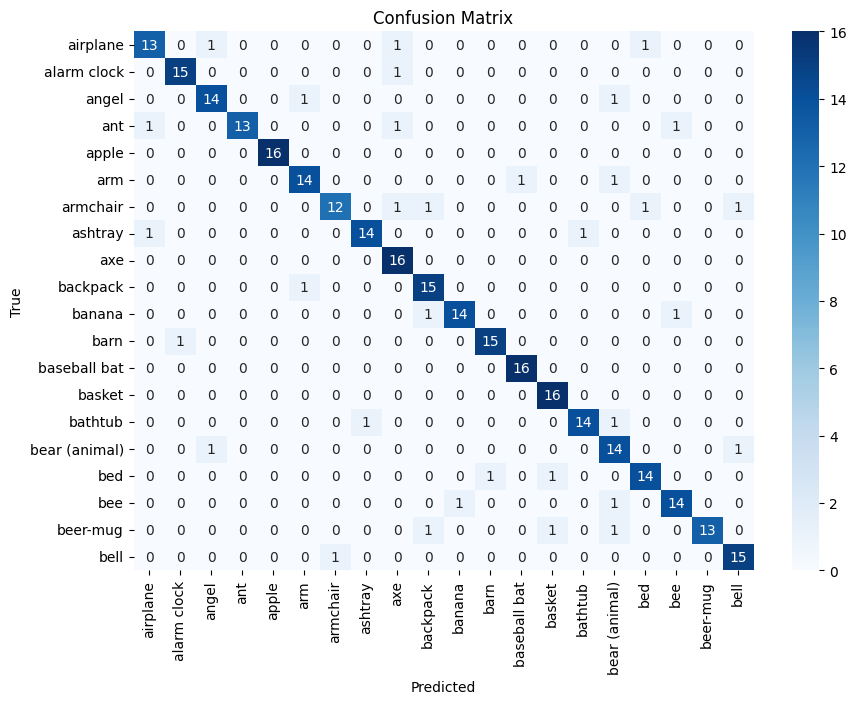

Classification Report:
               precision    recall  f1-score   support

     airplane       0.87      0.81      0.84        16
  alarm clock       0.94      0.94      0.94        16
        angel       0.88      0.88      0.88        16
          ant       1.00      0.81      0.90        16
        apple       1.00      1.00      1.00        16
          arm       0.88      0.88      0.88        16
     armchair       0.92      0.75      0.83        16
      ashtray       0.93      0.88      0.90        16
          axe       0.80      1.00      0.89        16
     backpack       0.83      0.94      0.88        16
       banana       0.93      0.88      0.90        16
         barn       0.94      0.94      0.94        16
 baseball bat       0.94      1.00      0.97        16
       basket       0.89      1.00      0.94        16
      bathtub       0.93      0.88      0.90        16
bear (animal)       0.74      0.88      0.80        16
          bed       0.88      0.88      0

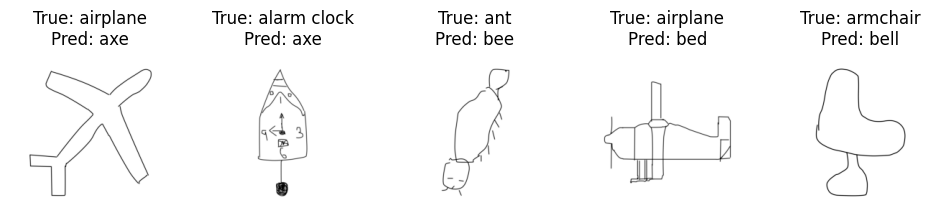

In [19]:
test_loss, test_acc, inputs, labels, preds = evaluate_model(fine_tuned_model, dataloaders, criterion)

print(f"Test Loss: {test_loss:.4f} Acc: {test_acc * 100:.2f}%")

plot_misclassified_images(inputs, labels, preds, num_images=5)

Rezultati su dobri, i za svaku od slika se može i razumeti zašto je sam model pogresio. [Ovde](https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/computational_classification/index.html) se mogu videti i rezultati na celom skupu podatak od autora Eitz, Mathias and Hays, James and Alexa, Marc. Ti rezultati jos dodatno potvrdjuju tezinu samog skupa podataka.

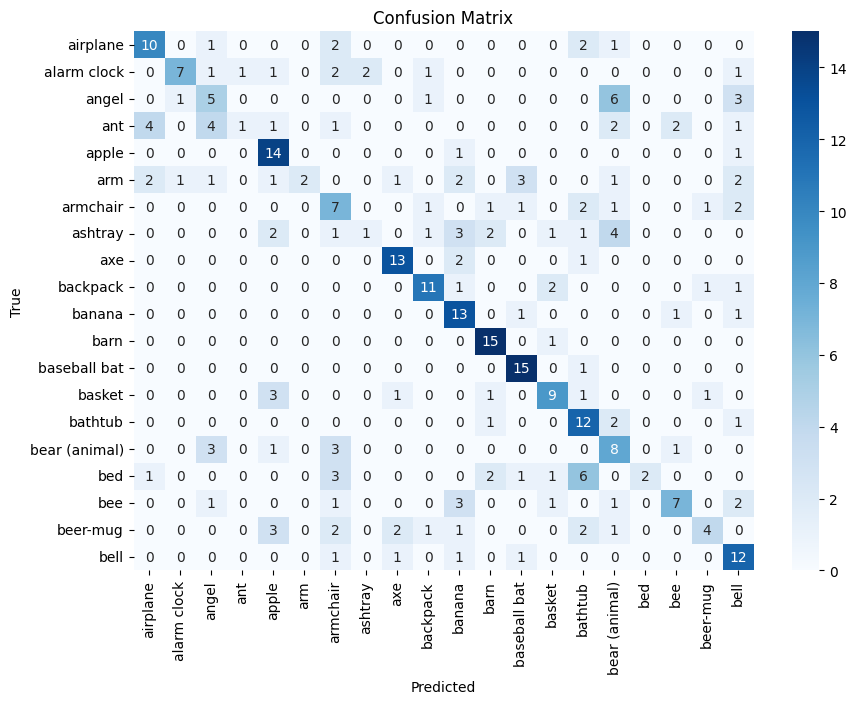

Classification Report:
               precision    recall  f1-score   support

     airplane       0.59      0.62      0.61        16
  alarm clock       0.78      0.44      0.56        16
        angel       0.31      0.31      0.31        16
          ant       0.50      0.06      0.11        16
        apple       0.54      0.88      0.67        16
          arm       1.00      0.12      0.22        16
     armchair       0.30      0.44      0.36        16
      ashtray       0.33      0.06      0.11        16
          axe       0.72      0.81      0.76        16
     backpack       0.69      0.69      0.69        16
       banana       0.48      0.81      0.60        16
         barn       0.68      0.94      0.79        16
 baseball bat       0.68      0.94      0.79        16
       basket       0.60      0.56      0.58        16
      bathtub       0.43      0.75      0.55        16
bear (animal)       0.30      0.50      0.37        16
          bed       1.00      0.12      0

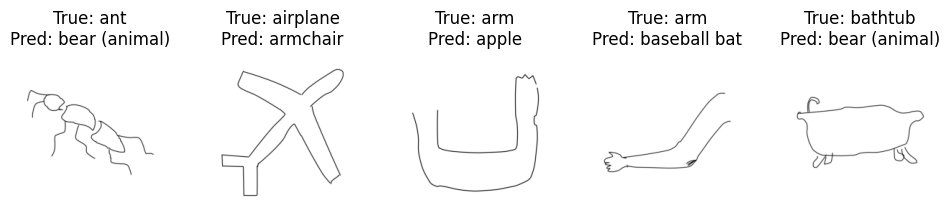

In [22]:
#Evaluacija base modela
test_loss, test_acc, inputs, labels, preds = evaluate_model(best_baseline_model, dataloaders, criterion)

print(f"Test Loss: {test_loss:.4f} Acc: {test_acc * 100:.2f}%")

plot_misclassified_images(inputs, labels, preds, num_images=5)

Kao sto se moze videti, rezultati base model-a su losi u odnosu na finetune-ovan.

## Definicija Custom CNN Modela

U ovoj ćeliji definišemo **CustomCNN** arhitekturu koja koristi više slojeva konvolucije i normalizacije sa globalnim prosečnim poolingom.

- **Model se sastoji od**:
  - **Konvolucioni slojevi**:
    - 6 konvolucionih slojeva sa veličinom kernela 3x3 i BatchNorm slojevima.
    - Svaki sloj prati ReLU aktivacija i MaxPool operacija, osim poslednjeg konvolucionog sloja.
  - **Global Average Pooling**:
    - Koristimo adaptivno globalno prosečni pooling pre potpuno povezanih slojeva kako bismo saželi informaciju.
  - **Dropout**:
    - Primena dropout regularizacije sa 50% verovatnoćom drop-ovanja tokom treninga.
  - **Fully connected slojevi**:
    - Dva potpuno povezana sloja, sa 1024 jedinice u prvom sloju, i 20 jedinica u poslednjem sloju za klasifikaciju na 20 klasa.

- **Konačna struktura**:
  - Model vraća klasifikacione rezultate posle prolaska kroz konvolucione i potpuno povezane slojeve.



In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CustomCNN(nn.Module):
    def __init__(self, num_classes=20, input_size=224):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.conv6 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(2048)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling

        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = F.relu(self.bn6(self.conv6(x)))

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = 20
custom_model = CustomCNN(num_classes=num_classes).to(device)

num_classes = 20
input_size = 224
custom_model = CustomCNN(num_classes=num_classes, input_size=input_size).to(device)

## Funkcija za inicijalizaciju težina

**Cilj funkcije**:
- Ova funkcija služi da pravilno inicijalizuje težine slojeva modela koristeći **He inicijalizaciju** (poznata kao Kaiming inicijalizacija). Ova metoda je korisna kod modela koji koriste **ReLU aktivacione funkcije**, kako bi se izbegli problemi poput **eksplodirajućih** ili **nestajućih gradijenata** tokom treninga.

### Detalji implementacije:

- **Argument `m`**: Ovo je pojedinačni sloj modela (npr. konvolucioni ili potpuno povezani sloj). Ova funkcija se obično koristi u kombinaciji sa PyTorch-ovom metodom `apply()` koja prolazi kroz sve slojeve u modelu.

- **Provera tipa sloja**:
  - Funkcija proverava da li je sloj tipa **`nn.Conv2d`** (konvolucioni sloj) ili **`nn.Linear`** (potpuno povezani sloj). Ako jeste, težine tog sloja se inicijalizuju He metodom.
  
### Kaiming/He inicijalizacija:

- **Inicijalizacija težina**:
  - `nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')`:
    - Ova linija koristi **Kaiming uniformnu inicijalizaciju** koja nasumično postavlja težine sloja iz uniformne distribucije. Ova metoda je dizajnirana tako da zadrži varijansu izlaznih vrednosti kroz slojeve stabilnom, posebno kada se koriste aktivacione funkcije poput **ReLU**. Argument `nonlinearity='relu'` govori PyTorch-u da koristi formulu pogodnu za ReLU funkciju.
  
- **Inicijalizacija bias-a**:
  - `if m.bias is not None: nn.init.constant_(m.bias, 0)`:
    - Ako sloj ima **bias (pristrasnost)**, on se postavlja na nulu, što je standardna praksa u treniranju dubokih neuronskih mreža, jer bias ne bi trebao imati nasumičnu početnu vrednost. Zero bias olakšava efikasniji start optimizacije modela.



In [24]:
def initialize_weights_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


=== Training Custom CNN Model ===
Epoch 1/75
----------


100%|██████████| 36/36 [00:30<00:00,  1.20it/s]


Train Loss: 3.3614 Acc: 0.1111
Val Loss: 2.6662 Acc: 0.1641

Epoch 2/75
----------


100%|██████████| 36/36 [00:28<00:00,  1.24it/s]


Train Loss: 2.5660 Acc: 0.1823
Val Loss: 2.5758 Acc: 0.1875

Epoch 3/75
----------


100%|██████████| 36/36 [00:28<00:00,  1.25it/s]


Train Loss: 2.4149 Acc: 0.2188
Val Loss: 3.5434 Acc: 0.1094

Epoch 4/75
----------


100%|██████████| 36/36 [00:28<00:00,  1.25it/s]


Train Loss: 2.2894 Acc: 0.2587
Val Loss: 2.2812 Acc: 0.2891

Epoch 5/75
----------


100%|██████████| 36/36 [00:28<00:00,  1.24it/s]


Train Loss: 2.1700 Acc: 0.2778
Val Loss: 2.8689 Acc: 0.1797

Epoch 6/75
----------


100%|██████████| 36/36 [00:28<00:00,  1.26it/s]


Train Loss: 2.1224 Acc: 0.3212
Val Loss: 2.0113 Acc: 0.3516

Epoch 7/75
----------


100%|██████████| 36/36 [00:30<00:00,  1.17it/s]


Train Loss: 2.0553 Acc: 0.3038
Val Loss: 2.0398 Acc: 0.3438

Epoch 8/75
----------


100%|██████████| 36/36 [00:28<00:00,  1.24it/s]


Train Loss: 1.9092 Acc: 0.3681
Val Loss: 2.0834 Acc: 0.3906

Epoch 9/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.24it/s]


Train Loss: 1.9344 Acc: 0.3689
Val Loss: 2.7002 Acc: 0.1875

Epoch 10/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


Train Loss: 1.7828 Acc: 0.4149
Val Loss: 1.7765 Acc: 0.4297

Epoch 11/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.24it/s]


Train Loss: 1.6818 Acc: 0.4583
Val Loss: 1.6731 Acc: 0.4844

Epoch 12/75
----------


100%|██████████| 36/36 [00:30<00:00,  1.18it/s]


Train Loss: 1.6586 Acc: 0.4774
Val Loss: 1.6534 Acc: 0.4922

Epoch 13/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.21it/s]


Train Loss: 1.6095 Acc: 0.4774
Val Loss: 1.5404 Acc: 0.5469

Epoch 14/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.22it/s]


Train Loss: 1.5729 Acc: 0.4896
Val Loss: 1.5858 Acc: 0.5078

Epoch 15/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


Train Loss: 1.5134 Acc: 0.5148
Val Loss: 1.5456 Acc: 0.5078

Epoch 16/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


Train Loss: 1.5182 Acc: 0.5208
Val Loss: 1.3964 Acc: 0.5547

Epoch 17/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


Train Loss: 1.4858 Acc: 0.5182
Val Loss: 1.4439 Acc: 0.5625

Epoch 18/75
----------


100%|██████████| 36/36 [00:33<00:00,  1.07it/s]


Train Loss: 1.4922 Acc: 0.5243
Val Loss: 1.4253 Acc: 0.5625

Epoch 19/75
----------


100%|██████████| 36/36 [00:31<00:00,  1.14it/s]


Train Loss: 1.4697 Acc: 0.5321
Val Loss: 1.5175 Acc: 0.5078

Epoch 20/75
----------


100%|██████████| 36/36 [00:31<00:00,  1.13it/s]


Train Loss: 1.4134 Acc: 0.5373
Val Loss: 1.3857 Acc: 0.5781

Epoch 21/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.22it/s]


Train Loss: 1.4390 Acc: 0.5642
Val Loss: 1.3835 Acc: 0.5859

Epoch 22/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.22it/s]


Train Loss: 1.3655 Acc: 0.5712
Val Loss: 1.3562 Acc: 0.6016

Epoch 23/75
----------


100%|██████████| 36/36 [00:38<00:00,  1.07s/it]


Train Loss: 1.3968 Acc: 0.5677
Val Loss: 1.3732 Acc: 0.5938

Epoch 24/75
----------


100%|██████████| 36/36 [00:30<00:00,  1.18it/s]


Train Loss: 1.4184 Acc: 0.5321
Val Loss: 1.3576 Acc: 0.5859

Epoch 25/75
----------


100%|██████████| 36/36 [00:31<00:00,  1.15it/s]


Train Loss: 1.3431 Acc: 0.5842
Val Loss: 1.3650 Acc: 0.5859

Epoch 26/75
----------


100%|██████████| 36/36 [00:32<00:00,  1.09it/s]


Train Loss: 1.3932 Acc: 0.5365
Val Loss: 1.3488 Acc: 0.6016

Epoch 27/75
----------


100%|██████████| 36/36 [00:30<00:00,  1.19it/s]


Train Loss: 1.4018 Acc: 0.5408
Val Loss: 1.3656 Acc: 0.5859

Epoch 28/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.20it/s]


Train Loss: 1.3750 Acc: 0.5521
Val Loss: 1.3497 Acc: 0.6016

Epoch 29/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


Train Loss: 1.3453 Acc: 0.5790
Val Loss: 1.3690 Acc: 0.5938

Epoch 30/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.20it/s]


Train Loss: 1.3770 Acc: 0.5686
Val Loss: 1.3688 Acc: 0.5938

Epoch 31/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.24it/s]


Train Loss: 1.3292 Acc: 0.5816
Val Loss: 1.3424 Acc: 0.6016

Epoch 32/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.22it/s]


Train Loss: 1.3567 Acc: 0.5781
Val Loss: 1.3495 Acc: 0.6094

Epoch 33/75
----------


100%|██████████| 36/36 [00:31<00:00,  1.13it/s]


Train Loss: 1.3761 Acc: 0.5625
Val Loss: 1.3471 Acc: 0.6016

Epoch 34/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.24it/s]


Train Loss: 1.4199 Acc: 0.5582
Val Loss: 1.3579 Acc: 0.5859

Epoch 35/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.22it/s]


Train Loss: 1.3765 Acc: 0.5625
Val Loss: 1.3642 Acc: 0.5859

Epoch 36/75
----------


100%|██████████| 36/36 [00:29<00:00,  1.21it/s]


Train Loss: 1.4178 Acc: 0.5564
Val Loss: 1.3588 Acc: 0.5859
Early stopping at epoch 36
Training complete in 19m 32s
Best Val Acc: 0.6016
Custom CNN Train Accuracy: 60.16%



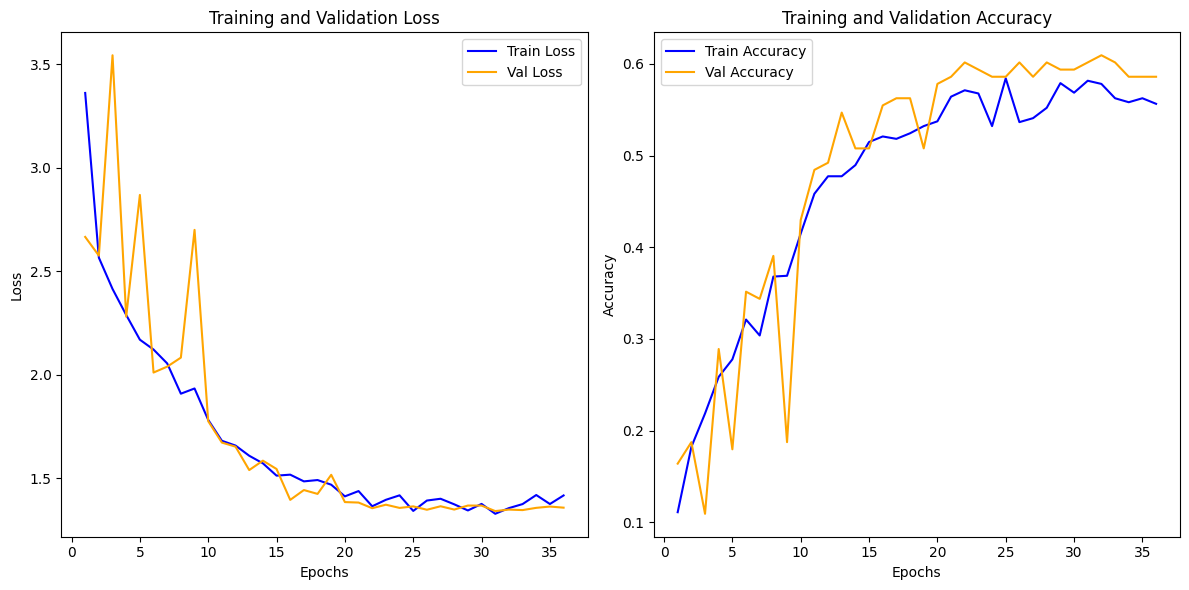

<Figure size 640x480 with 0 Axes>

In [25]:
learning_rate_custom = 1e-3
weight_decay_custom = 1e-5
num_epochs_custom = 75

optimizer_custom = optim.Adam(custom_model.parameters(), lr=learning_rate_custom, weight_decay=weight_decay_custom)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_custom, mode='min', patience=2, verbose=True)


print("=== Training Custom CNN Model ===")

best_custom_model, custom_acc, custom_train_losses, custom_val_losses, custom_train_accuracies, custom_val_accuracies = train_model(
    custom_model,
    dataloaders,
    criterion,
    optimizer_custom,
    num_epochs=num_epochs_custom,
    is_finetune=False,
    patience=5,
    scheduler = scheduler,
    weight_init = initialize_weights_he
)

print(f"Custom CNN Train Accuracy: {custom_acc * 100:.2f}%\n")

plot_metrics(custom_train_losses, custom_val_losses, custom_train_accuracies, custom_val_accuracies, is_finetune=False)


Model je u jednom trenutku pokazao znake preprilagođavanja, ali je uspeo da se oporavi i poboljša performanse.

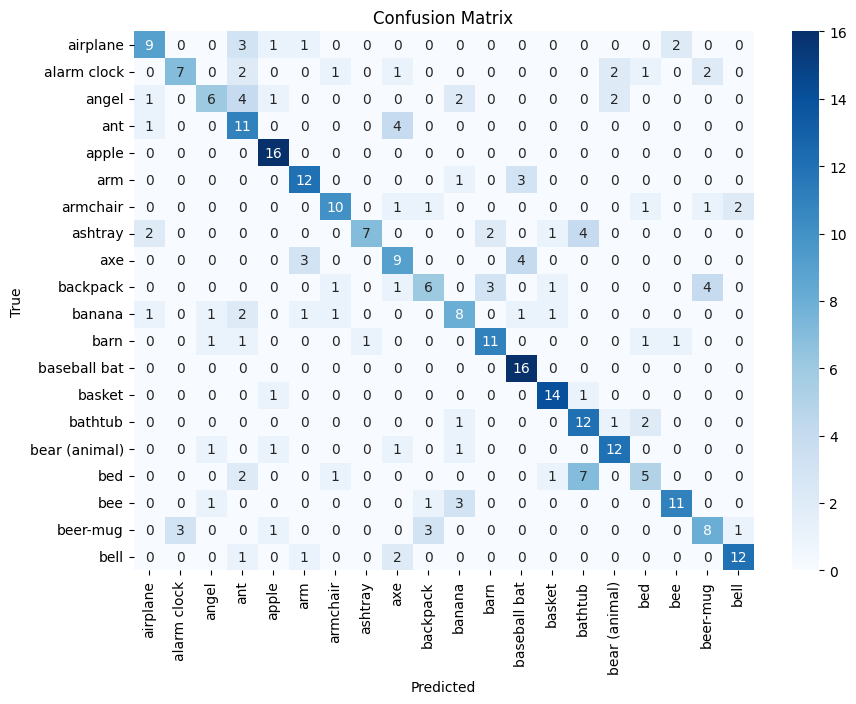

Classification Report:
               precision    recall  f1-score   support

     airplane       0.64      0.56      0.60        16
  alarm clock       0.70      0.44      0.54        16
        angel       0.60      0.38      0.46        16
          ant       0.42      0.69      0.52        16
        apple       0.76      1.00      0.86        16
          arm       0.67      0.75      0.71        16
     armchair       0.71      0.62      0.67        16
      ashtray       0.88      0.44      0.58        16
          axe       0.47      0.56      0.51        16
     backpack       0.55      0.38      0.44        16
       banana       0.50      0.50      0.50        16
         barn       0.69      0.69      0.69        16
 baseball bat       0.67      1.00      0.80        16
       basket       0.78      0.88      0.82        16
      bathtub       0.50      0.75      0.60        16
bear (animal)       0.71      0.75      0.73        16
          bed       0.50      0.31      0

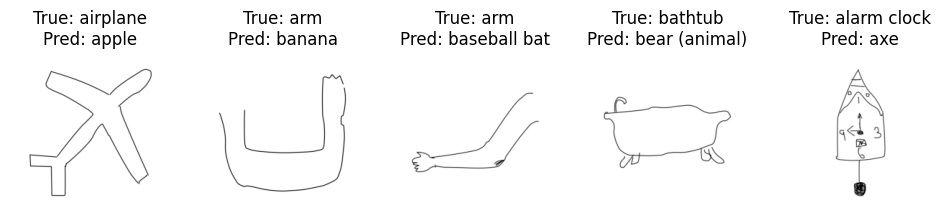

In [26]:
#Evaluacija base modela
test_loss, test_acc, inputs, labels, preds = evaluate_model(custom_model, dataloaders, criterion)

print(f"Test Loss: {test_loss:.4f} Acc: {test_acc * 100:.2f}%")

plot_misclassified_images(inputs, labels, preds, num_images=5)

Rezultati su bolji u poređenju sa osnovnim modelom, ali su i dalje nezadovoljavajući. Na određenim klasama model je pokazao solidne performanse, ali su ukupni rezultati slabi. Uzrok tome može biti nedovoljno efikasna arhitektura mreže kao i složenost samih podataka.

##**Zakljucak**

Od svih isprobanih modela, finetunovani model pokazao je najbolje performanse, što ga čini najprikladnijim za ovu vrstu zadatka. Ovaj rezultat može se pripisati efikasnoj kombinaciji prenosa znanja iz prethodno treniranog modela i prilagođavanja specifičnostima zadatog skupa podataka.

Međutim, važno je napomenuti da je skup podataka izuzetno zahtevan za treniranje. Sadrži veliki broj klasa i složene obrasce, što je dodatno otežano korišćenjem augmentacija poput rotacija i brisanja delova slika tokom treniranja. Ovi faktori su značajno otežali proces učenja za druge, manje složene modele, čime su slabiji rezultati kod tih modela bili očekivani.

Finetunovani model je uspeo da iskoristi prednosti prenetih težina i postepeno se prilagodio karakteristikama podataka, dok se drugi modeli suočavali sa prekomernim preprilagođavanjem ili su imali poteškoće sa generalizacijom. Iako su rezultati finetunovanog modela zadovoljavajući, postoji prostor za dalje poboljšanje uklanjanjem preprilagodjavanja.

Generalno, finetuning se pokazao kao moćan pristup u rešavanju ovakvih problema, ali kompleksnost skupa podataka zahteva oprez i dodatna unapređenja kako bi se postigli još bolji rezultati.